# Run and compare belief propagation in pgmpy for a Bayesian Network
The purpose of this tutorial is to compare the results of inference from implementations of belief propagation by the `pgmpy` and `beliefs` libraries.

We consider 4 different networks:
 1. Simple Model - 14 nodes, each with Bernoulli OR CPDs
 2. Custom CPD model - 4 nodes, where 2 of the nodes have custom CPDs (not OR or AND)
 3. Mixed AND and OR CPD model - 6 nodes, 5 with Bernoulli OR CPDs and 1 with Bernoulli AND CPD 
 4. Many parents model* - 18 parent nodes sharing a single child node with a Bernoulli OR CPD

For each network, we initialize a Bayesian model from a list of directed edges (tuples), visualize the network, then run inference using `pgmpy`.  All models are polytrees -- only one path exists between any two nodes in the graph.

*Note: We don't actually run inference with `pgmpy` on the "Many parents model", where one child node has 18 parents.  The algorithm never converges because of the amount of memory (exponential in the number of parents of a node) required to work with explicit tabular conditional probability distributions (CPDs).  In contrast, `beliefs` implements shortcuts (see [BernoulliAndNode and BernoulliOrNode)](https://github.com/drivergroup/beliefs/blob/generic_discrete_factor/beliefs/models/belief_update_node_model.py) for computing the marginal probabilities of nodes with deterministic CPDs like ANDs and ORs.

Finally, note that `pgmpy` does not provide the ability to provide virtual evidence, i.e. to modify the likelihood of an unobserved node in the graph based on evidence that does not correspond to any nodes in the graph (see the method [`_run_belief_propagation`](https://github.com/drivergroup/beliefs/blob/13053909cb47464a800f708c0954f7def8a0deb4/beliefs/inference/belief_propagation.py)), so comparisons with `beliefs` involving inference with virtual evidence are not available.


### Requirements
Note that `pgmpy` is pinned to `networkx` v1.11, whereas `beliefs` is written for v2.0, which is incompatible with `pgmpy`.  We therefore can't use `pgmpy` and `beliefs` in the same environment. Requirements for running this notebook are:
- pgmpy
- numpy
- networkx==1.11
- matplotlib

In [1]:
import numpy as np

import networkx as nx
import warnings
warnings.filterwarnings("ignore")  # draw_networkx triggers Matplotlib deprecated warnings

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation

import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 8)

# I. Simple model
- 14 nodes, each corresponding to a Bernoulli random variable (a variable that only has two possible states: e.g. False/True or 0/1).
- Each node is a Bernoulli random variable, with an 'OR' conditional probability distribution, i.e. if at least one of the node's parents is True, then the node is True, otherwise False.  Nodes without parents default to a flat prior probability.
- The same model is defined as `simple_model` in [test_belief_propagation.py](https://github.com/drivergroup/beliefs/blob/master/tests/test_belief_propagation.py)

## 1. Initialize Bayesian Model and visualize network

In [2]:
simple_edges = [('1', '3'), ('2', '3'), ('3', '5'), ('4', '5'), ('5', '10'), ('5', '9'), ('6', '8'), ('7', '8'), 
                ('8', '9'), ('9', '11'), ('9', 'x'), ('14', 'x'), ('x', '12'), ('x', '13')]
simple_model = BayesianModel(simple_edges)
print("Nodes in the graph: ", simple_model.nodes())

Nodes in the graph:  ['14', '10', '11', '1', '4', '2', '6', '13', '7', '5', '12', '9', 'x', '8', '3']


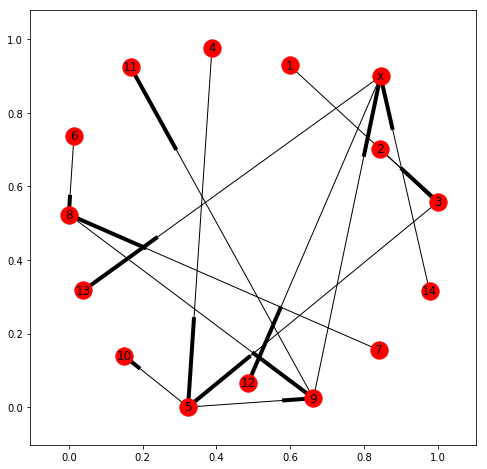

In [3]:
nx.draw_networkx(simple_model, pos=nx.spring_layout(simple_model, k=0.12, iterations=20))

## 2. Define and associate CPDs for each node in the Bayesian Model

Define a helper function for generating the values of an OR conditional probability distribution (CPD) for a variable given the number of parents.

In [4]:
def get_tabular_OR_cpd_values(n_parents):
    if n_parents == 0:
        values = [[0.5], [0.5]]
    else:
        values = (np.array([1.,] + [0.]*(2**n_parents-1) + [0.,] + [1.]*(2**n_parents-1))
                  .reshape(2, 2**n_parents)
                  .tolist())
    return values

In [5]:
print("Example OR CPD values for Bernoulli variable with 2 parents: ", get_tabular_OR_cpd_values(2))

Example OR CPD values for Bernoulli variable with 2 parents:  [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 1.0, 1.0]]


In [6]:
simple_model_cpds = {}
for node in simple_model.nodes():
    parents = simple_model.predecessors(node)
    n_parents = len(parents)
    cpd_values = get_tabular_OR_cpd_values(n_parents)
    simple_model_cpds[node] = TabularCPD(variable=node,
                                         variable_card=2,
                                         values=cpd_values,
                                         evidence=parents,
                                         evidence_card=[2]*n_parents)

In [7]:
print("CPD for variable x, with parents '9' and '14'")
print(simple_model_cpds['x'])

CPD for variable x, with parents '9' and '14'
╒═════╤══════╤══════╤══════╤══════╕
│ 9   │ 9_0  │ 9_0  │ 9_1  │ 9_1  │
├─────┼──────┼──────┼──────┼──────┤
│ 14  │ 14_0 │ 14_1 │ 14_0 │ 14_1 │
├─────┼──────┼──────┼──────┼──────┤
│ x_0 │ 1.0  │ 0.0  │ 0.0  │ 0.0  │
├─────┼──────┼──────┼──────┼──────┤
│ x_1 │ 0.0  │ 1.0  │ 1.0  │ 1.0  │
╘═════╧══════╧══════╧══════╧══════╛


In [8]:
print("CPD for variable '7', with no parents")
print(simple_model_cpds['7'])

CPD for variable '7', with no parents
╒═════╤═════╕
│ 7_0 │ 0.5 │
├─────┼─────┤
│ 7_1 │ 0.5 │
╘═════╧═════╛


In [9]:
# Associate the CPDs we just defined per node with the Bayesian model
simple_model.add_cpds(*simple_model_cpds.values())

In [10]:
# Is the model valid?
simple_model.check_model()

True

## 3. Run inference using pgmpy's implementation of the belief propagation algorithm

In [11]:
# instantiate the inference model
infer_simple_model = BeliefPropagation(simple_model)

### Define four cases for which we want to run inference.  Each case corresponds to a set of observations of variables, i.e. a set of evidence.
- 'test' is the name of the corresponding beliefs tests in [test_belief_propagation.py](https://github.com/drivergroup/beliefs/blob/master/tests/test_belief_propagation.py)
- 'evidence' is the set of variables and their observed values for that case
- 'expected' is the expected outcome of the inference, which matches the expected outcomes in test_belief_propagation.py

In [12]:
cases = [{'test': 'test_no_evidence_simple_model', 
          'evidence': {},
          'expected': {'x': 0.984375, '14': 0.5, '7': 0.5, '2': 0.5, '3': 0.75, '13': 0.984375,
                       '6': 0.5, '4': 0.5, '8': 0.75, '10': 0.875, '1': 0.5, '9': 0.96875,
                       '12': 0.984375, '5': 0.875, '11': 0.96875}},
         {'test': 'test_positive_evidence_node_13',
          'evidence': {'13': 1},
          'expected': {'6': 0.50793650793650791, '3': 0.76190476190476186, 
                       '9': 0.98412698412698407, '8': 0.76190476190476186, 
                       'x': 1.0, '4': 0.50793650793650791, '11': 0.98412698412698407,
                       '1': 0.50793650793650791, '5': 0.88888888888888884, 
                       '2': 0.50793650793650791, '12': 1.0, '14': 0.50793650793650791, 
                       '13': 1, '10': 0.88888888888888884, '7': 0.50793650793650791}},
         {'test': 'test_positive_evidence_node_5',
          'evidence': {'5': 1},
          'expected': {'1': 0.5714285714285714, '5': 1, '3': 0.8571428571428571, '10': 1.0, 
                       '8': 0.75, '2': 0.5714285714285714, '4': 0.5714285714285714, '6': 0.5, 
                       '7': 0.5, '14': 0.5, '12': 1.0, '13': 1.0, '11': 1.0, '9': 1.0, 
                       'x': 1.0}},
         {'test': 'test_positive_evidence_node_5_negative_evidence_node_14',
          'evidence': {'5': 1, '14': 0},
          'expected': {'6': 0.5, '7': 0.5, '9': 1.0, '3': 0.8571428571428571, 
                       '1': 0.57142857142857151, '12': 1.0, 'x': 1.0, '11': 1.0, '14': 0.0, 
                       '2': 0.57142857142857151, '4': 0.5714285714285714, '5': 1.0, '10': 1.0, 
                       '13': 1.0, '8': 0.75}}]

Define helper functions for extracting and comparing inference results.

In [13]:
def get_probability_of_True(query):
    """Return the marginal probability of a Bernoulli variable being True
    
    Args
        query: a result returned by inference, 
            e.g. query = belief_propagation.query(variables, evidence)
    Returns
        infer: dict,
            key, value pairs of {var: P(var is True)}
    """
    infer = {}
    for variable, factor in query.items():
        infer[variable] = factor.values[1]
    return infer

In [14]:
def compare_expected_to_observed(expected, observed):
    """Compare inference results between expected and observed, where both are dictionaries
    of key, value pairs of {var: P(var is True)}
    """
    assert set(expected.keys()) == set(observed.keys()), set(observed.keys())-set(expected.keys())
    for node in expected:
        assert np.allclose(expected[node], observed[node], rtol=1e-05, atol=1e-10)

### Run inference for each test case, then compare to expected results

In [15]:
for test_case in cases:
    print("\nTest case: ", test_case['test'])
    
    # pgmpy doesn't allow you to include evidence vars in the set of query variables:
    evidence_vars = test_case['evidence'].keys()
    variables = set(simple_model.nodes()) - set(evidence_vars)
    [test_case['expected'].pop(var) for var in evidence_vars]
    
    query = infer_simple_model.query(variables=variables, evidence=test_case['evidence'])
    results = get_probability_of_True(query)
    print("Marginal probability of True: ", results)
    
    compare_expected_to_observed(test_case['expected'], results)


Test case:  test_no_evidence_simple_model
Marginal probability of True:  {'14': 0.5, '10': 0.87500000000000011, '11': 0.96875000000000011, '1': 0.5, '4': 0.50000000000000011, '2': 0.50000000000000011, '6': 0.5, '13': 0.984375, '9': 0.96875, '5': 0.875, '12': 0.984375, '7': 0.5, 'x': 0.984375, '8': 0.75, '3': 0.75000000000000011}

Test case:  test_positive_evidence_node_13
Marginal probability of True:  {'14': 0.50793650793650791, '10': 0.88888888888888895, '11': 0.98412698412698418, '1': 0.50793650793650791, '4': 0.50793650793650802, '2': 0.50793650793650791, '6': 0.50793650793650791, '7': 0.50793650793650791, '5': 0.88888888888888895, '12': 1.0, '9': 0.98412698412698418, 'x': 1.0, '8': 0.76190476190476186, '3': 0.76190476190476197}

Test case:  test_positive_evidence_node_5
Marginal probability of True:  {'14': 0.5, '10': 1.0, '11': 1.0, '1': 0.5714285714285714, '4': 0.5714285714285714, '2': 0.5714285714285714, '6': 0.5, '13': 1.0, '9': 1.0, '12': 1.0, '7': 0.5, 'x': 1.0, '8': 0.7499

### Special case: conflicting evidence
Notice how in the case of conflicting evidence, inference with pgmpy returns `nan`s, whereas beliefs throws a `ConflictingEvidenceError`.

In [16]:
query = infer_simple_model.query(variables=set(simple_model.nodes()) - {'x', '5'}, evidence={'x': 0, '5': 1})
results = get_probability_of_True(query)

print("Test case: test_conflicting_evidence")
print("Results: ", results)

Test case: test_conflicting_evidence
Results:  {'14': nan, '10': nan, '11': nan, '1': nan, '4': nan, '2': nan, '6': nan, '13': nan, '9': nan, '12': nan, '7': nan, '8': nan, '3': nan}


# II. Custom CPD model
- 4 nodes
- Y-shaped model, with parents 'u' and 'v' as Bernoulli variables, 'x' a node with cardinality 3 and custom CPD, 'y' a node with cardinality 2 and custom CPD
- The same model is defined as `custom_cpd_model` in [test_belief_propagation.py](https://github.com/drivergroup/beliefs/blob/master/tests/test_belief_propagation.py)

## 1. Initialize Bayesian Model and visualize network

In [17]:
custom_cpd_model = BayesianModel([('u', 'x'), ('v', 'x'), ('x', 'y')])
print("Nodes in the graph: ", custom_cpd_model.nodes())

Nodes in the graph:  ['y', 'v', 'x', 'u']


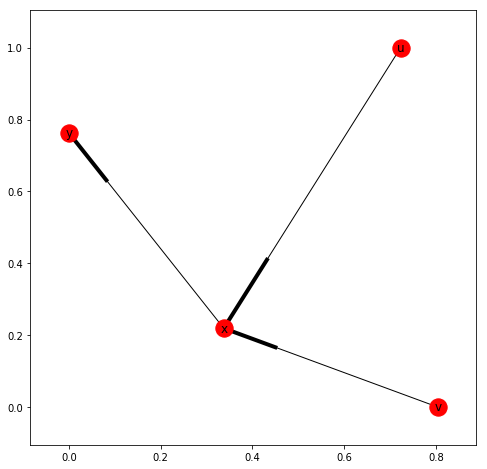

In [18]:
nx.draw_networkx(custom_cpd_model, pos=nx.spring_layout(custom_cpd_model, k=0.10, iterations=10))

## 2. Define and associate CPDs for each node in the Bayesian Model

In [19]:
custom_cpd_x = TabularCPD(variable='x',
                        variable_card=3,
                        values=[[0.2, 0, 0.3, 0.1],
                                [0.4, 1, 0.7, 0.2],
                                [0.4, 0, 0, 0.7]],
                        evidence=['u', 'v'],
                        evidence_card=[2, 2])

custom_cpd_y = TabularCPD(variable='y',
                          variable_card=2,
                          evidence=['x'],
                          evidence_card=[3],
                          values=[[0.3, 0.1, 0],
                                  [0.7, 0.9, 1]])

cpd_u = TabularCPD(variable='u', variable_card=2, values=[[0.5], [0.5]])
cpd_v = TabularCPD(variable='v', variable_card=2, values=[[0.5], [0.5]])

In [20]:
custom_cpd_model.add_cpds(custom_cpd_x, custom_cpd_y, cpd_u, cpd_v)

In [21]:
custom_cpd_model.check_model()

True

## 3. Run inference using pgmpy's implementation of the belief propagation algorithm

In [22]:
# instantiate the inference model
infer_custom_cpd_model = BeliefPropagation(custom_cpd_model)

Two cases for which we want to run inference.

In [23]:
cases = [{'test': 'test_no_evidence_custom_cpd_model', 
          'evidence': {},
          'expected': {'x': [0.15, 0.575, 0.275],
                       'v': [0.5, 0.5],
                       'u': [0.5, 0.5],
                       'y': [0.1025, 0.8975]}},
         {'test': 'test_evidence_custom_cpd_model',
          'evidence': {'x': 1},
          'expected': {'x': [0., 1., 0.],
                       'v': [0.47826087, 0.52173913],
                       'u': [0.60869565, 0.39130435],
                       'y': [0.1, 0.9]}}]

In [24]:
for test_case in cases:
    print("\nTest case: ", test_case['test'])
    
    # pgmpy doesn't allow you to include evidence vars in the set of query variables:
    evidence_vars = test_case['evidence'].keys()
    variables = set(custom_cpd_model.nodes()) - set(evidence_vars)
    [test_case['expected'].pop(var, None) for var in evidence_vars]
    
    query = infer_custom_cpd_model.query(variables=variables, evidence=test_case['evidence'])
    results = {var: factor.values.tolist() for var, factor in query.items()}
    print("Marginal probability of True: ", results)
    
    compare_expected_to_observed(test_case['expected'], results)


Test case:  test_no_evidence_custom_cpd_model
Marginal probability of True:  {'y': [0.10250000000000001, 0.8975000000000001], 'v': [0.5, 0.5], 'x': [0.15, 0.5750000000000001, 0.275], 'u': [0.5, 0.5]}

Test case:  test_evidence_custom_cpd_model
Marginal probability of True:  {'y': [0.1, 0.9], 'v': [0.47826086956521735, 0.5217391304347826], 'u': [0.6086956521739131, 0.391304347826087]}


# III. Mixed AND and OR CPD model
- 6 nodes total
- All nodes are Bernoulli with OR CPDs, except 'z' has an AND CPD
- The same model is defined as `mixed_cpd_model` in [test_belief_propagation.py](https://github.com/drivergroup/beliefs/blob/master/tests/test_belief_propagation.py)

## 1. Initialize Bayesian Model and visualize network

In [25]:
mixed_cpd_model = BayesianModel([('u', 'x'), ('v', 'x'), ('x', 'y'), ('x', 'z'), ('w', 'z')])
print("Nodes in the graph: ", mixed_cpd_model.nodes())

Nodes in the graph:  ['v', 'z', 'y', 'w', 'x', 'u']


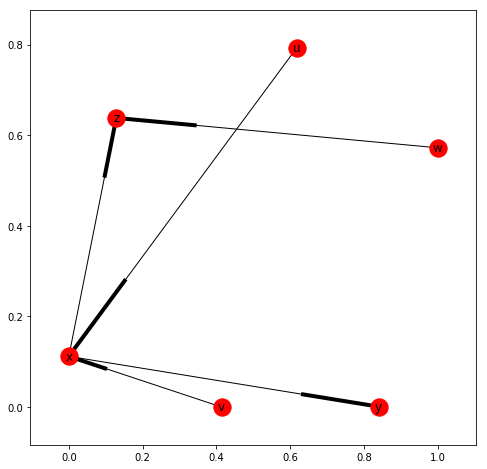

In [26]:
nx.draw_networkx(mixed_cpd_model, pos=nx.spring_layout(mixed_cpd_model, k=0.10, iterations=10))

## 2. Define and associate CPDs for each node in the Bayesian Model

In [27]:
mixed_cpd_model_cpds = {}

# First define CPDs for OR nodes
for node in {'y', 'u', 'v', 'w', 'x'}:
    parents = mixed_cpd_model.predecessors(node)
    n_parents = len(parents)
    cpd_values = get_tabular_OR_cpd_values(n_parents)
    mixed_cpd_model_cpds[node] = TabularCPD(variable=node,
                                            variable_card=2,
                                            values=cpd_values,
                                            evidence=parents,
                                            evidence_card=[2]*n_parents)
    values = (np.array([1.,] + [0.]*(2**n_parents-1) + [0.,] + [1.]*(2**n_parents-1))
                  .reshape(2, 2**n_parents)
                  .tolist())

# Define CPD for the single AND node
mixed_cpd_model_cpds['z'] = TabularCPD(variable='z',
                                       variable_card=2,
                                       values=[[1,1,1,0], [0,0,0,1]],
                                       evidence=['w', 'x'],
                                       evidence_card=[2, 2])

In [28]:
mixed_cpd_model.add_cpds(*mixed_cpd_model_cpds.values())

In [29]:
mixed_cpd_model.check_model()

True

## 3. Run inference using pgmpy's implementation of the belief propagation algorithm

In [30]:
# instantiate the inference model
infer_mixed_cpd_model = BeliefPropagation(mixed_cpd_model)

In [31]:
cases = [{'test': 'test_no_evidence_mixed_cpd_model', 
          'evidence': {},
          'expected': {'x': 1-0.5**2, 'z': 0.5*(1-0.5**2), 'v': 0.5, 'u': 0.5, 'y': 0.75, 'w': 0.5}},
         {'test': 'test_x_false_w_true_mixed_cpd_model',
          'evidence': {'x': 0, 'w': 1},
          'expected': {'u': 0, 'v': 0, 'y': 0, 'z': 0}},
         {'test': 'test_x_true_w_true_mixed_cpd_model',
          'evidence': {'x': 1, 'w': 1},
          'expected': {'y': 1, 'z': 1, 'u': 2/3, 'v': 2/3}}]

In [32]:
for test_case in cases:
    print("\nTest case: ", test_case['test'])
    
    # pgmpy doesn't allow you to include evidence vars in the set of query variables:
    evidence_vars = test_case['evidence'].keys()
    variables = set(mixed_cpd_model.nodes()) - set(evidence_vars)
    [test_case['expected'].pop(var, None) for var in evidence_vars]
    
    query = infer_mixed_cpd_model.query(variables=variables, evidence=test_case['evidence'])
    results = get_probability_of_True(query)

    print("Marginal probability of True: ", results)
    
    compare_expected_to_observed(test_case['expected'], results)


Test case:  test_no_evidence_mixed_cpd_model
Marginal probability of True:  {'w': 0.5, 'z': 0.375, 'y': 0.75, 'x': 0.75, 'v': 0.5, 'u': 0.5}

Test case:  test_x_false_w_true_mixed_cpd_model
Marginal probability of True:  {'y': 0.0, 'v': 0.0, 'z': 0.0, 'u': 0.0}

Test case:  test_x_true_w_true_mixed_cpd_model
Marginal probability of True:  {'y': 1.0, 'v': 0.66666666666666663, 'z': 1.0, 'u': 0.66666666666666663}


# IV. Many parents model
- 19 nodes: 18 parents sharing a single child, node '62.'
- All nodes are Bernoulli, and the child has an OR CPD
- The same model is defined as `many_parents_model` in [test_belief_propagation.py](https://github.com/drivergroup/beliefs/blob/master/tests/test_belief_propagation.py)

## 1. Initialize Bayesian Model and visualize network

In [33]:
many_parents_edges = [('96', '62'), ('80', '62'), ('98', '62'), ('100', '62'), ('86', '62'), 
                      ('102', '62'), ('104', '62'), ('64', '62'), ('106', '62'), ('108', '62'), 
                      ('110', '62'), ('112', '62'), ('114', '62'), ('116', '62'), ('118', '62'),
                      ('122', '62'), ('70', '62'), ('94', '62')]
many_parents_model = BayesianModel(many_parents_edges)
print("Nodes in the graph: ", many_parents_model.nodes())

Nodes in the graph:  ['100', '86', '106', '122', '94', '62', '104', '110', '96', '116', '112', '114', '108', '98', '102', '64', '80', '118', '70']


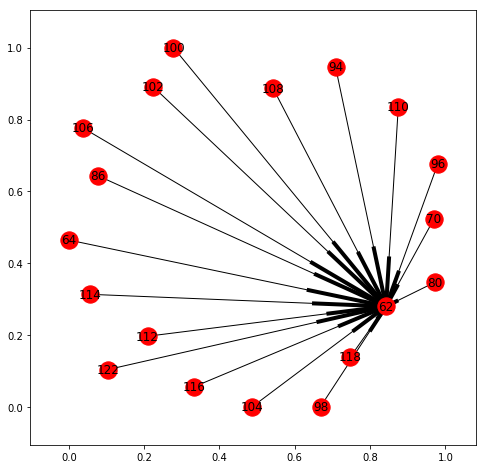

In [34]:
nx.draw_networkx(many_parents_model, pos=nx.spring_layout(many_parents_model, k=0.10, iterations=10))

## 2. Define and associate CPDs for each node in the Bayesian Model

In [35]:
many_parents_model_cpds = {}

for node in many_parents_model.nodes():
    parents = many_parents_model.predecessors(node)
    n_parents = len(parents)
    cpd_values = get_tabular_OR_cpd_values(n_parents)
    many_parents_model_cpds[node] = TabularCPD(variable=node,
                                               variable_card=2,
                                               values=cpd_values,
                                               evidence=parents,
                                               evidence_card=[2]*n_parents)

In [36]:
# Associate the CPDs we just defined per node with the Bayesian model
many_parents_model.add_cpds(*many_parents_model_cpds.values())
many_parents_model.check_model()

True

## 3. Run inference using pgmpy's implementation of the belief propagation algorithm

We don't run inference for this model because pgmpy's implementation of belief propagation does not converge.  The code is provided below (if you run it, be prepared to have to force-quit or wait for it to time out). 
```
# instantiate the inference model
infer_many_parents_model = BeliefPropagation(many_parents_model)

query = infer_many_parents_model.query(variables=many_parents_model.nodes(), evidence={})
```